In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

import pickle #for saving/loading trained classifiers


In [2]:


# Load data
file_data = '..' + os.sep + 'data' + os.sep + 'okapi_data_metadata.csv'
df = pd.read_csv(file_data)

# Prepare labels
label = np.array(df['diagnosis'])
cancer = np.copy(label)
cancer[cancer == "BCC"] = 1
cancer[cancer == "MEL"] = 1
cancer[cancer == "SCC"] = 1
cancer[cancer == "ACK"] = 0
cancer[cancer == "NEV"] = 0
cancer[cancer == "SEK"] = 0
cancer = cancer.astype(int)  # Ensure that labels are integers

# Load features
annotation_data = '..' + os.sep + 'features' + os.sep + 'features_okapi_images.csv'
our_annotations = pd.read_csv(annotation_data)
features = our_annotations[['asymmetry', 'colour', 'dots']].values

# Split data for training and testing (final evaluation)
X_train, X_test, y_train, y_test = train_test_split(features, cancer, test_size=0.1, stratify=cancer)

# Print data shapes to illustrate split amounts
print(f"Total features shape: {features.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training labels:\n{y_train}")
print(f"Testing labels:\n{y_test}")


Total features shape: (106, 3)
Training set shape: (95, 3)
Testing set shape: (11, 3)
Training labels:
[1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0
 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1
 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1]
Testing labels:
[1 1 0 0 0 1 1 0 0 1 0]


Decision Tree Test Accuracy: 0.6363636363636364


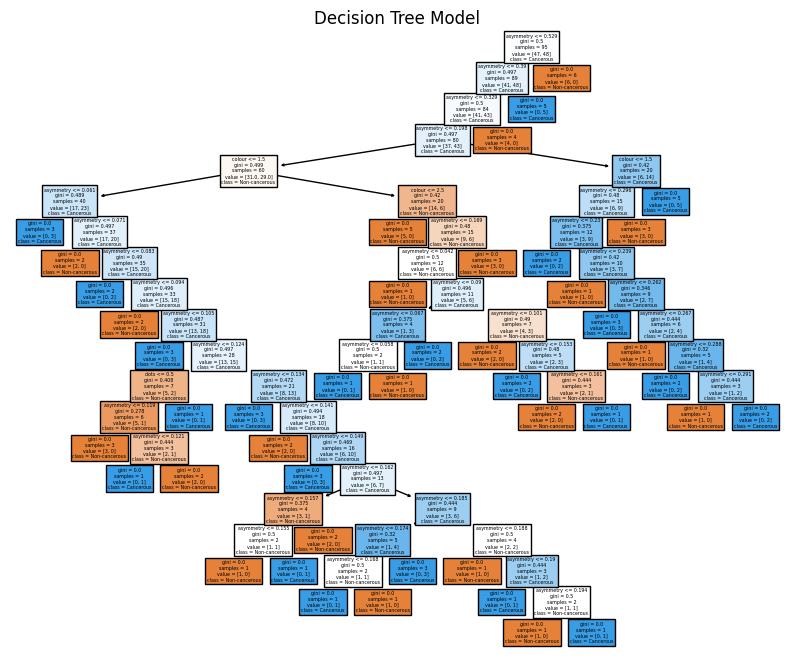

In [3]:

# Decision Tree Model
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
y_pred_tree = dec_tree.predict(X_test)
balanced_accuracy_tree = balanced_accuracy_score(y_test, y_pred_tree)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Test Accuracy:", accuracy_tree)

# Plot the Decision Tree
plt.figure(figsize=(10, 8))
plot_tree(dec_tree, filled=True, feature_names=['asymmetry', 'colour', 'dots'], class_names=['Non-cancerous', 'Cancerous'])
plt.title("Decision Tree Model")
plt.show()


In [4]:

# K-Nearest Neighbors Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
balanced_accuracy_knn = balanced_accuracy_score(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Test Accuracy:", accuracy_knn)

# Output results for both models
print(f"Decision Tree Accuracy: {accuracy_tree:.4f}")
print(f"KNN Accuracy: {accuracy_knn:.4f}")


KNN Test Accuracy: 0.36363636363636365
Decision Tree Accuracy: 0.6364
KNN Accuracy: 0.3636


In [5]:
#Kfolding, and running on both models
num_folds = 10
num_classifiers = 3
kfold = KFold(n_splits = num_folds)

acc_val = np.empty([num_folds,num_classifiers])

for i_data, (train_index, val_index) in enumerate(kfold.split(X_train,y_train)):
    #the number of training data sets created will therefore also be according to the num_folds
    x_variant_train = X_train[train_index,:]
    y_variant_train = y_train[train_index]
    x_variant_val = X_train[val_index,:]
    y_variant_val = y_train[val_index]

    dec_tree.fit(x_variant_train, y_variant_train)
    y_tree_prediction = dec_tree.predict(x_variant_val)
    acc_val[i_data,0] = balanced_accuracy_score(y_variant_val, y_tree_prediction)
    #print(f"This iteration of decision tree score is: {acc_val[i_data,0]}")

    knn1 = KNeighborsClassifier(n_neighbors=1)
    knn1.fit(x_variant_train, y_variant_train)
    y_pred_knn1 = knn1.predict(x_variant_val)
    bal_acc_knn1 = balanced_accuracy_score(y_variant_val, y_pred_knn1)
    acc_val[i_data,1] = bal_acc_knn1
    #print("KNN1 Test Accuracy:", bal_acc_knn1)

    knn5 = KNeighborsClassifier(n_neighbors=5)
    knn5.fit(x_variant_train, y_variant_train)
    y_pred_knn5 = knn5.predict(x_variant_val)
    bal_acc_knn5 = balanced_accuracy_score(y_variant_val, y_pred_knn5)
    acc_val[i_data,2] = bal_acc_knn5
    #print("KNN5 Test Accuracy:", bal_acc_knn5)


print(acc_val)

[[0.52380952 0.52380952 0.54761905]
 [0.52380952 0.52380952 0.33333333]
 [0.25       0.1875     0.75      ]
 [0.54166667 0.5        0.29166667]
 [0.41666667 0.375      0.20833333]
 [0.75       0.75       0.41666667]
 [0.5        0.5        0.41666667]
 [0.775      0.775      0.475     ]
 [0.16666667 0.16666667 0.16666667]
 [0.325      0.2        0.2       ]]


In [6]:
#Average over all folds
average_acc = np.mean(acc_val,axis=0) 
   
print('Classifier 1 average accuracy={:.5f} '.format(average_acc[0]))
print('Classifier 2 average accuracy={:.5f} '.format(average_acc[1]))
print('Classifier 3 average accuracy={:.5f} '.format(average_acc[2]))

Classifier 1 average accuracy=0.47726 
Classifier 2 average accuracy=0.45018 
Classifier 3 average accuracy=0.38060 


In [7]:
#The best classifier is.....
print("The best is:")
if average_acc[0] > average_acc[1] and average_acc[0] > average_acc[2]:
    classifier = DecisionTreeClassifier()
    print("DT")
elif average_acc[1] > average_acc[0] and average_acc[1] > average_acc[2]:
    classifier = KNeighborsClassifier(1)
    print("KNN1")
else:
    classifier = KNeighborsClassifier(5)
    print("KNN5")

The best is:
DT


In [8]:
#training this model on our entire dataset
classifier = classifier.fit(features, cancer)

In [9]:
filename = 'groupOkapi_classifier.sav'
pickle.dump(classifier, open(filename, 'wb'))